# Ensembling/Stacking in Python (Korean ver.)

- author : **Yewon Kang**
- notebook : https://www.kaggle.com/dolylupec/ensembling-stacking-in-python-titanic-dataset
- dataset : https://www.kaggle.com/c/titanic
- original author : https://www.kaggle.com/arthurtok 

**Ensemble** 이란? 여러개의 머신러닝 모델의 결과를 합쳐서 성능을 높이는 방법.

### 이 노트북에서 사용하는 앙상블 기법
- Ensemble 모델 (Random Forest, Extra Trees, Adaboost, Gradient Boosting)
- Out-of-Fold
- Stacking

**Table of Contents**
- Feature Enginnering
- Visualization
- out-of-fold
- 초기 모델 설정 (parameter)
    - Random Forest Classifier
    - Extra Trees Classifier
    - Adaboost Classifier
    - Gradient Boosting Classifier
    - Support Vector Machine (Classifier)
- Interactive feature importances via Plotly scatterplots,barplot
- Stacking (2번째 학습)
  - XGBoost

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# stacking에서 5개의 base model 사용
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
# sklearn.cross_validation -> sklearn.model_selection
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleansing

In [2]:
# Load in train and test datasets
# path 변경
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
train.shape, test.shape

((891, 12), (418, 11))

### Feature Engineering

In [4]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [5]:
# Create new feature FamilySize as a combination of SibSp and Parch
# SibSp : 형제자매, Parch : 부모자식
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create a new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Remove all NULLS in the Embarked column
# embarked : 출발지
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
# Fare : 요금
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
# 이후에 지울 feature임
for dataset in full_data:
    for dataset in full_data:
        age_avg = dataset['Age'].mean()
        age_std = dataset['Age'].std()
        age_null_count = dataset['Age'].isnull().sum()
        age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
        dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
        dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [6]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search('  ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [7]:
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping 'Rare'
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [8]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female' : 0, 'male':1}).astype(int)
    
    # Mapping titles
    title_mapping = {'Mr' : 1, 'Miss' : 2, 'Mrs' : 3, 'Master' : 4, 'Rare' : 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S' : 0, 'C' : 1, 'Q' : 2}).astype(int)
    
    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [9]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

## Visualization

In [10]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,0.0
1,1,1,0,2,0,3,1,51,1,2,0,0.0
2,1,3,0,1,0,1,0,22,0,1,1,0.0


### Pearson Correlation Heatmap
correlation(상관도) 보기 위해
- +1과 -1 사이의 값을 가짐
    - +1은 완벽한 양의 선형 상관 관계, 0은 선형 상관 관계 없음, -1은 완벽한 음의 선형 상관 관계

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

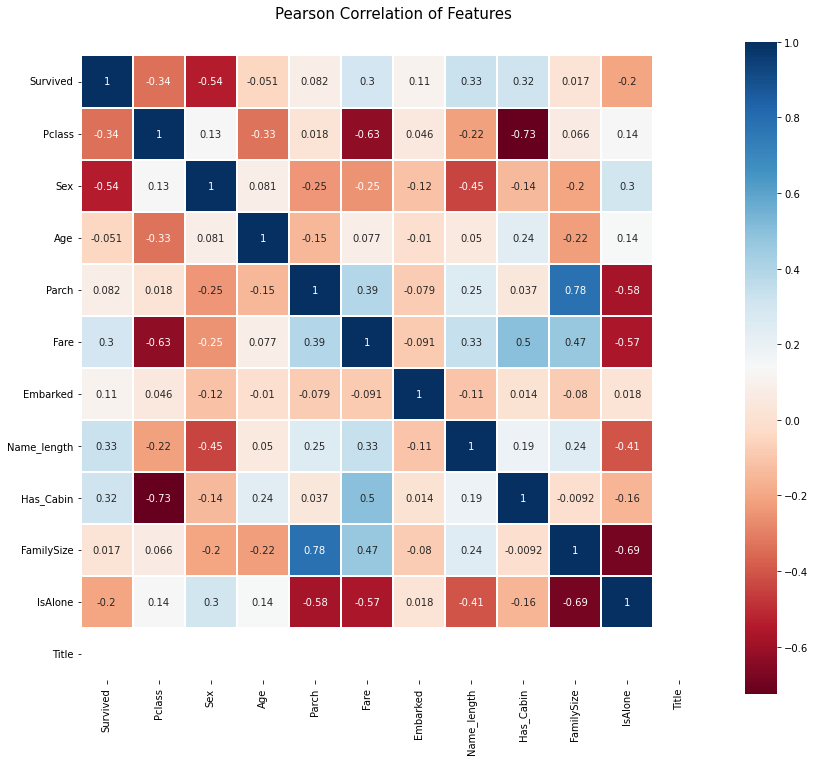

In [11]:
colormap = plt.cm.RdBu
plt.figure(figsize = (14,12))
plt.title('Pearson Correlation of Features', y=1.05, size = 15)
sns.heatmap(train.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = 'white', annot=True)

### Pairplots

두 feature간의 분포를 보기 위함

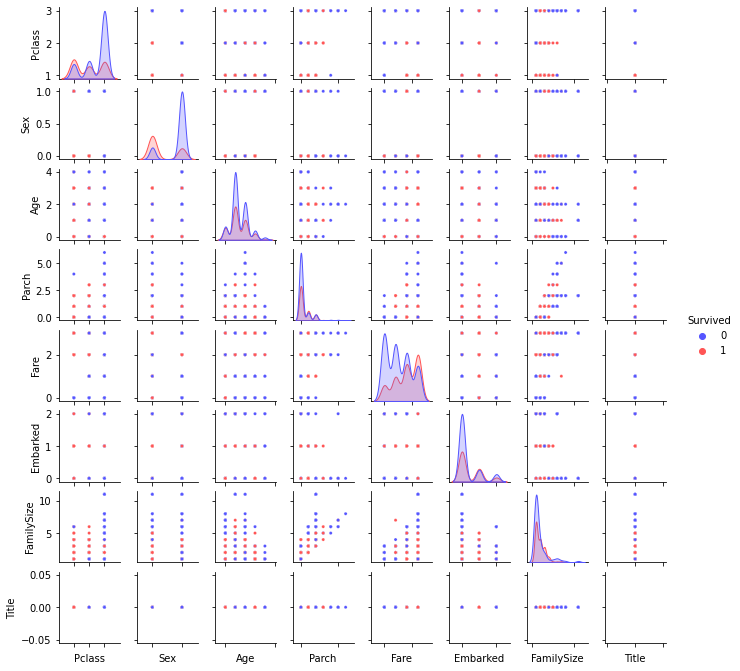

In [12]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

## Ensembling & Stacking models

- Stacking 
    - base classifier들의 output(prediction)을 second-level-model(meta 모델)의 input으로 사용
- 전체 데이터로 base classifier를 train하고 해당 output을 메타모델에 사용하면 과적합(overfitting)될 수 있음
    - data를 train, test로 분리한 뒤, train data만 cross validation으로 훈련하고 test data로 평가

### Helpers via Python Classes

- 5개의 다른 classifier에 중복 코드 작성 → 좀 더 효율적으로 class로
    - 여기에서는 크게 차이 없음, 모델이 100개 이상정도일 때 유용할 듯
- Sklearn 라이브러리에서 호출 가능한 모델 5개 (rf, et, ada, gb, svc)
- sklearn classifier 내에 이미 존재하는 해당 메소드를 호출하는 클래스의 메소드

In [13]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED) # 변경 : n_folds -> n_splits, dataset_length(=ntrain) 입력 X https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [14]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed = 0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params) # unpacking을 두번 일어남. hyperparameter를 dictionary
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)
        
# Class to extend XGboost classifier

### Out-of-Fold Predictions

- K-Fold Cross Validation 
    - train data를 K개(여기에서는 5개)로 쪼개서 사용

- Stacking 위해 모델마다 결과물 
    - 결과 내는 방식 : Cross Validation을 활용한 OOF 방식 사용
        - CV : K-fold, fold = 5

- get_oof
    - train : fold별로 결과 내서 concat
    - train : 모델의 결과를 평균

In [15]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    # kf -> kf.split(dataset)으로 문법 변경
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models
sklearn에서 해당 classifier class를 제공함

1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifier
4. Gradient Boosting classifier
5. Support Vector Machine

1~4 : tree-based model

### Base models

**Tree-based model**
- bagging과 boosting 대부분 tree-based model
- train하기 쉽고, 빠름
- **Random Forest**
    - bagging의 대표적인 알고리즘
        - bagging : 같은 classifier 사용, 데이터 샘플링을 서로 다르게 가져가면서 train해 voting을 수행
    - Decision Tree 여러개의 결과를 평균
    - 여러개의 DT를 전체 데이터에서 bagging 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 classifier가 voting을 통해 결과
- **Extra Tree**
    - Random Forest와 비슷
    - split을 할 때 무작위로 feature 선정
    - 빠른 속도, bias/variance 낮음


**Boosting**
- 여러개의 tree-based classifier가 순차적으로 train - predict, 잘못 예측한 데이터에 weight을 부여하면서 오류를 개선하는 방식
- **AdaBoost** 
    - classifier가 순차적으로 오류 값에 대해 가중치를 부여한 예측 결정 기준을 모두 결합해 예측 수행
- **Gradient Boosting**
    - AdaBoost와 유사, 가중치 업데이트를 경사 하강법(gradient descent)를 이용

**Support Vector Machine** 
- decision boundary를 데이터와 가장 멀리 떨어지게 결정하는 방법

### tree-based model parameters

- `n_jobs` : training에서 사용된 CPU 코어 수 (-1 : 전체 사용)
- `n_estimators` : classification tree의 개수 (default : 10)
    - 여기에 사용된 모델들은 tree-based 모델 (boosting model 포함)
- `max_depth` : tree의 최대 깊이 (overfitting 고려해서 적절하게)
- `verbose` : training 과정 출력할지 여부 
    - 0 : 텍스트 숨김, 3 : 모든 반복에서 프로세스 출력

In [16]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    # 'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    # 'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    # 'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters
svc_params = {
    'kernel' : 'linear',
    'C': 0.025
}

각 classifier를 공통된 형식으로 사용할 수 있게 class로 만들어 놓음 (class 굳이 필요 없음)

In [17]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating NumPy arrays out of our train and test sets

Dataframe 형태의 data를 numpy 형태로 추출

In [18]:
# Create Numpy arrays of train, test and target(Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data (column명을 제외한 값들 뽑아냄)
x_test = test.values # Creates an array of the test data

out-of-fold로 5개의 base classifier로 예측 (output 생성)

In [19]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees 
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers

tree-based model은 feature importance기준으로 tree를 나누므로 feature_importance 추출 가능

In [20]:
# tree based model에서는 feature importance를 뽑을 수 있음
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.13700325 0.35687485 0.04251837 0.02728378 0.0939545  0.03079921
 0.14920252 0.07675592 0.06634942 0.01925818 0.        ]
[0.13368506 0.49103364 0.03789366 0.02105047 0.06520991 0.03150785
 0.06360502 0.09156695 0.03982556 0.02462189 0.        ]
[0.026 0.01  0.02  0.06  0.034 0.008 0.758 0.006 0.076 0.002 0.   ]
[0.11515721 0.38053094 0.07118738 0.0243073  0.05136363 0.02851674
 0.1969813  0.04648557 0.07098231 0.01448762 0.        ]


In [21]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591, 0.02854371,
               0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811, 0.028157,
               0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028, 0.008, 0.012, 0.05866667, 0.032, 0.008, 0.04666667, 0. , 0.05733333,
                0.73866667, 0.01066667]
gb_features = [0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395, 0.04778854,
               0.05965792, 0.02774745, 0.07462718, 0.4593142, 0.01340093]

In [22]:
# 시각화 편하게 하기 위해 dataframe 생성
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame({'features': cols, 
                                  'Random Forest feature importances': rf_features,
                                  'Extra Trees feature importances': et_features,
                                  'AdaBoost feature importances': ada_features,
                                  'Gradient Boost feature importances': gb_features})

### Interactive feature importances via Plotly scatterplots

In [23]:
# Scatter plot
# data
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale = 'Portland',
        showscale = True),
    text = feature_dataframe['features'].values)
data = [trace]

# 제목, 축 등의 layout
layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [24]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Extra Trees Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'scatter2010')

In [25]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'AdaBoost Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)

fig = go.Figure(data=data, layout = layout)
py.iplot(fig, filename = 'scatter2010')

In [26]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Gradient Boosting Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend =  False
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'scatter2010')

모델에 따라 서로 다른 feature importance
- Random Forest, Extra Tree : Sex, FamilySize
- AdaBoost, Gradient Descent : IsAlone

Ensemble 
- 서로 다른 feature를 잘 보는 (상관관계가 낮은) 모델끼리 성능이 좋아질 것으로 예상

In [27]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis = 1) # axis = 1 : computes the mean row-wise
feature_dataframe.head()

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028000,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008000,0.038893,0.159062
2,Age,0.044327,0.031296,0.012000,0.072378,0.040000
3,Parch,0.022492,0.015916,0.058667,0.026286,0.030840
4,Fare,0.054326,0.055258,0.032000,0.111944,0.063382


### Plotly Barplot of Average Feature Importances

원래는 비교를 위해서는 barplot으로 시각화해야함

In [28]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
    x = x,
    y = y,
    width = 0.5,
    marker = dict(
        color = feature_dataframe['mean'].values,
        colorscale = 'Portland',
        showscale = True,
        reversescale = False
    ),
    opacity = 0.6
)]

layout = go.Layout(
    autosize = True,
    title = 'Barplot of Mean Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'bar-direct-labels')

## Second-Level Predictions from the First-level Output

### First-level output as new features
- ravel() : 다차원 배열(array)을 1차원 배열로 평평하게 펴주는 NumPy 함수
- https://rfriend.tistory.com/349

In [29]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(),
    'ExtraTrees': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel()
})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set
- 각 base model output의 상관관계를 시각화를 통해 확인
    - Second Level 모델에서의 input

In [30]:
data = [
    go.Heatmap(
        z = base_predictions_train.astype(float).corr().values,
        x = base_predictions_train.columns.values,
        y = base_predictions_train.columns.values,
            colorscale = 'Viridis',
            showscale = True,
            reversescale = True
    )
]

py.iplot(data, filename = 'labelled-heatmap')

In [31]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis = 1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis = 1)

### Second level learning model via XGBoost
- XGBoost : https://xgboost.readthedocs.io/en/latest/

#### XGBoost 
- tree-based model 중 가장 높은 성능
- GBM 기반, 단점인 수행 시간 및 regularization 문제 해결, 병렬 CPU 환경에서 병렬 학습 빠름
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [32]:
gbm = xgb.XGBClassifier(
    n_estimators = 2000,
    max_depth = 4,
    min_child_weight = 2,
    gamma = 0.9,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic', 
    nthread = -1,
    scale_pos_weight=1
).fit(x_train, y_train)
predictions = gbm.predict(x_test)

[15:13:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [33]:
# Generate Submission File
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId,
                                  'Survived': predictions})
StackingSubmission.to_csv('StackingSubmission.csv', index=False)